In [1]:
import sys
sys.path.append("../")

from all_models import *

In [2]:
import os
import string
import numpy as np

import seaborn
import matplotlib.pyplot as plt

import torch

import torch.nn.functional as F
import torch.optim as optim

class Task(object):

    def __init__(self, max_len=10, vocab_size=3):
        super(Task, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        assert self.vocab_size <= 26, "vocab_size needs to be <= 26 since we are using letters to prettify LOL"

    def next_batch(self, batchsize=100, signal=None):
        if signal is not None:
            signal = string.ascii_uppercase.index(signal)
            signal = np.eye(self.vocab_size)[np.ones((batchsize, 1), dtype=int) * signal]
        else:
            signal = np.eye(self.vocab_size)[np.random.choice(np.arange(self.vocab_size), [batchsize, 1])]
        seq = np.eye(self.vocab_size)[np.random.choice(np.arange(self.vocab_size), [batchsize, self.max_len])]
        x = np.concatenate((signal, seq), axis=1)
        y = np.expand_dims(np.eye(self.max_len + 1)[np.sum(np.argmax(signal, axis=2) == (np.argmax(seq, axis=2)), axis=1)], axis=1)
        return x, y

    def prettify(self, samples):
        samples = samples.reshape(-1, self.max_len + 1, self.vocab_size)
        idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
        # This means max vocab_size is 26
        dictionary = np.array(list(string.ascii_uppercase))
        return dictionary[idx]

def train(max_len=10,
          vocab_size=3,
          hidden=64,
          pos_enc=False,
          num_enc_layers=1,
          batchsize=100,
          steps=2000,
          print_every=50,
          savepath='models/',
          save_file_name='ckpt.pt'):

    os.makedirs(savepath, exist_ok=True)
    model = PosEncLayersAttentionModel(pos_enc=pos_enc,
                           num_enc_layers=num_enc_layers)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=250, verbose=True)
    task = Task(max_len=max_len, vocab_size=vocab_size)

    loss_hist = []
    for i in range(steps):
        minibatch_x, minibatch_y = task.next_batch(batchsize=batchsize)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            minibatch_x = torch.Tensor(minibatch_x)
            minibatch_y = torch.Tensor(minibatch_y)
            out, _, _ = model(minibatch_x)
            loss = F.cross_entropy(
                out.transpose(1, 2),
                minibatch_y.argmax(dim=2))
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss)
        if (i + 1) % print_every == 0:
            print("Iteration {} - Loss {}".format(i + 1, loss))
        loss_hist.append(loss.detach().numpy())

    print("Iteration {} - Loss {}".format(i + 1, loss))
    print("Training complete!")
    torch.save(model.state_dict(), savepath + '/' + save_file_name)
    return loss_hist


def test(max_len=10,
         vocab_size=3,
         hidden=64,
         pos_enc=False,
         num_enc_layers=1,
         savepath='models/ckpt.pt',
         plot=True):

    model = PosEncLayersAttentionModel(pos_enc=pos_enc,
                           num_enc_layers=num_enc_layers)
    model.load_state_dict(torch.load(savepath))
    task = Task(max_len=max_len, vocab_size=vocab_size)

    samples, labels = task.next_batch(batchsize=1)
    print("\nInput: \n{}".format(task.prettify(samples)))
    model.eval()
    with torch.set_grad_enabled(False):
        predictions, attention, input_pos_enc = model(torch.Tensor(samples))
    predictions = predictions.detach().numpy()
    predictions = predictions.argmax(axis=2)
    attention = attention.detach().numpy()

    print("\nPrediction: \n{}".format(predictions))
    print("\nEncoder-Decoder Attention: ")
    for i, output_step in enumerate(attention[0]):
        print("Output step {} attended mainly to Input steps: {}".format(
            i, np.where(output_step >= np.max(output_step))[0]))
        print([float("{:.3f}".format(step)) for step in output_step])

    if plot:
        fig, ax = plt.subplots()
        seaborn.heatmap(
            attention[0],
            yticklabels=["output_0"],
            xticklabels=task.prettify(samples).reshape(-1),
            ax=ax,
            cmap='plasma',
            cbar=True,
            cbar_kws={"orientation": "horizontal"})
        ax.set_aspect('equal')
        ax.set_title("Encoder-Decoder Attention")
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
        plt.show()

    if pos_enc:
        input_pos_enc = input_pos_enc.detach().numpy()
        print("\nL2-Norm of Input Positional Encoding:")
        print([
            float("{:.3f}".format(step))
            for step in np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]])

        if plot:
            fig2, ax2 = plt.subplots()
            seaborn.heatmap(
                [np.linalg.norm(input_pos_enc, ord=2, axis=2)[0]],
                vmin=0.,
                # vmax=.5,
                yticklabels=["L2-Norm"],
                xticklabels=task.prettify(samples).reshape(-1),
                ax=ax2,
                cmap='plasma',
                cbar=True,
                cbar_kws={"orientation": "horizontal"})
            ax2.set_aspect('equal')
            ax2.set_title("Positional Encodings L2-Norm")
            for tick in ax2.get_yticklabels():
                tick.set_rotation(0)
            plt.show()
    return samples, labels, predictions, attention, input_pos_enc

In [3]:
task = Task()
samples, labels = task.next_batch()

In [4]:
# (batchsize, max_len + 1, vocab_size)
samples.shape

(100, 11, 3)

In [5]:
samples[0]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [6]:
# (batchsize, 1, max_len + 1)
labels.shape

(100, 1, 11)

In [7]:
labels[0]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

# Without Positional encodings

In [8]:
_ = train(print_every=250, pos_enc=False, save_file_name='ckpt-without_enc.pt')

Iteration 250 - Loss 1.689664602279663
Iteration 500 - Loss 1.3698970079421997
Iteration 750 - Loss 1.4354346990585327
Epoch 00815: reducing learning rate of group 0 to 1.0000e-04.
Iteration 1000 - Loss 1.3376893997192383
Epoch 01096: reducing learning rate of group 0 to 1.0000e-05.
Iteration 1250 - Loss 1.3112941980361938
Epoch 01373: reducing learning rate of group 0 to 1.0000e-06.
Iteration 1500 - Loss 1.3424094915390015
Iteration 1750 - Loss 1.2936427593231201
Iteration 2000 - Loss 1.3348960876464844
Iteration 2000 - Loss 1.3348960876464844
Training complete!



Input: 
[[['C']
  ['C']
  ['A']
  ['B']
  ['C']
  ['C']
  ['B']
  ['B']
  ['A']
  ['C']
  ['A']]]

Prediction: 
[[2]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [3 6 7]
[0.086, 0.086, 0.091, 0.098, 0.086, 0.086, 0.098, 0.098, 0.091, 0.086, 0.091]


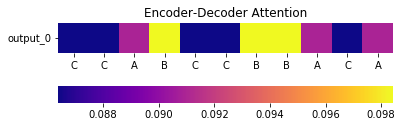

In [9]:
_ = test(pos_enc=False, savepath='models/ckpt-without_enc.pt')

# With Positional encodings

In [10]:
loss_hist = train(print_every=250, pos_enc=True, num_enc_layers=1, save_file_name='ckpt-with_enc.pt')

Iteration 250 - Loss 1.7806118726730347
Iteration 500 - Loss 0.6497786045074463
Iteration 750 - Loss 0.4624967873096466
Iteration 1000 - Loss 0.2693803310394287
Iteration 1250 - Loss 0.16812540590763092
Iteration 1500 - Loss 0.12893645465373993
Iteration 1750 - Loss 0.1828707754611969
Epoch 01770: reducing learning rate of group 0 to 1.0000e-04.
Iteration 2000 - Loss 0.11968713998794556
Iteration 2000 - Loss 0.11968713998794556
Training complete!



Input: 
[[['B']
  ['A']
  ['B']
  ['C']
  ['A']
  ['B']
  ['A']
  ['C']
  ['A']
  ['C']
  ['C']]]

Prediction: 
[[2]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0]
[0.384, 0.061, 0.055, 0.066, 0.061, 0.055, 0.061, 0.066, 0.061, 0.065, 0.065]


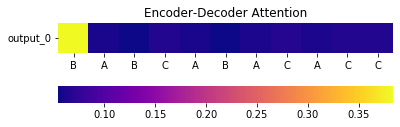


L2-Norm of Input Positional Encoding:
[1.235, 0.535, 0.523, 0.539, 0.526, 0.509, 0.542, 0.543, 0.541, 0.516, 0.546]


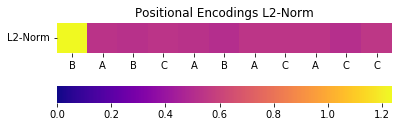

(array([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.],
         [0., 0., 1.]]]),
 array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
 array([[2]]),
 array([[[0.38379818, 0.06104202, 0.05464882, 0.06569191, 0.0605548 ,
          0.05484021, 0.06119511, 0.06640542, 0.06124883, 0.06511965,
          0.06545506]]], dtype=float32),
 array([[[-2.22514346e-02, -5.01235798e-02, -1.10804230e-01,
          -1.79626256e-01,  8.45286399e-02,  5.64367846e-02,
           1.67156011e-02,  7.73680061e-02, -1.92584634e-01,
          -1.64269775e-01,  2.28398934e-01,  5.27668968e-02,
          -8.48705396e-02, -2.01125875e-01, -4.93963622e-02,
          -8.14052820e-02, -1.19007174e-02,  3.13848965e-02,
          -2.26647019e-01,  1.45480379e-01, -1.20660216e-01,
           4.91922386e-02,  6.81375265e-02,  1.71912313e-01,
  

In [11]:
test(pos_enc=True, num_enc_layers=1, savepath='models/ckpt-with_enc.pt')

# With positional encodings and more encoder layers

In [12]:
loss_hist = train(print_every=250, pos_enc=True,
                  num_enc_layers=6, save_file_name='ckpt-6_enc_layers.pt')

Iteration 250 - Loss 1.0872899293899536
Iteration 500 - Loss 0.6068181395530701
Iteration 750 - Loss 0.15106478333473206
Iteration 1000 - Loss 0.027460329234600067
Iteration 1250 - Loss 0.012173328548669815
Iteration 1500 - Loss 0.5628243088722229
Epoch 01669: reducing learning rate of group 0 to 1.0000e-04.
Iteration 1750 - Loss 0.02081538736820221
Epoch 01920: reducing learning rate of group 0 to 1.0000e-05.
Iteration 2000 - Loss 0.013842154294252396
Iteration 2000 - Loss 0.013842154294252396
Training complete!



Input: 
[[['B']
  ['A']
  ['A']
  ['B']
  ['C']
  ['C']
  ['C']
  ['A']
  ['C']
  ['B']
  ['B']]]

Prediction: 
[[3]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0]
[0.878, 0.01, 0.01, 0.015, 0.012, 0.012, 0.012, 0.01, 0.012, 0.015, 0.015]


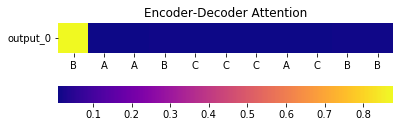


L2-Norm of Input Positional Encoding:
[1.401, 0.3, 0.301, 0.317, 0.304, 0.316, 0.308, 0.3, 0.306, 0.291, 0.309]


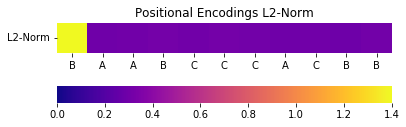

(array([[[0., 1., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.]]]),
 array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]]),
 array([[3]]),
 array([[[0.8777731 , 0.00968149, 0.00967571, 0.01492754, 0.01211717,
          0.01212234, 0.01211286, 0.00966833, 0.01211374, 0.01491944,
          0.01488842]]], dtype=float32),
 array([[[-4.17647623e-02, -7.06875697e-02,  1.69356018e-01,
           1.94532573e-01, -6.57075271e-02,  1.64218143e-01,
          -5.65354116e-02,  7.32267350e-02, -1.33716717e-01,
          -1.20741002e-01,  1.11322748e-02, -8.96810815e-02,
           2.71674216e-01, -2.92514145e-01,  2.06490517e-01,
          -1.06994912e-01,  3.91185075e-01, -1.30304947e-01,
           8.44871104e-02, -1.48794368e-01, -1.30253017e-01,
          -1.57329310e-02,  4.01121825e-02, -5.36860526e-02,
  

In [13]:
test(pos_enc=True, num_enc_layers=6, savepath='models/ckpt-6_enc_layers.pt')